In [ ]:
import os
packages = ["cloudscraper", "dash","gensim","sumy","pyLDAvis","nltk"]
for package in packages:
    os.system(f"pip install {package} -q")
    
import nltk
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)    

In [ ]:
import re
import random
import requests
import json
import torch
import pandas as pd
import seaborn as sns
from collections import Counter
from collections import defaultdict
import cloudscraper
import dash
from dash import dcc, html, dash_table, Input, Output
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from nltk.tokenize import word_tokenize

In [ ]:
file_path = "parsed_data.json"
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

businessinsider_entries = []
calcalistech_entries = []
cnbc_entries = []
geekwire_entries = []
techcrunch_entries = []

for entry in data:
    source = entry.get("Source", "")
    if source.startswith("https://www.businessinsider.com"):
        businessinsider_entries.append(entry)
    elif source.startswith("https://www.calcalistech.com"):
        calcalistech_entries.append(entry)
    elif source.startswith("https://www.cnbc.com"):
        cnbc_entries.append(entry)
    elif source.startswith("https://www.geekwire.com"):
        geekwire_entries.append(entry)
    elif source.startswith("https://techcrunch.com"):
        techcrunch_entries.append(entry)

**Scraping for [www.businessinsider.com](www.businessinsider.com)**

In [ ]:
def extract_businessinsider(url):
    response = requests.get(url)
    html_content = " ".join(response.text.split())
    pattern = r'<div> <section class="post-content typography " data-track-content="" data-post-type="post" data-user-status="anonymous" >(.*?)</section> </div>'
    matches = re.findall(pattern, html_content, re.DOTALL)

    extracted_content = matches[0].strip() if matches else ""
    cleaned_content = re.sub(r'(?s)<(script|style).*?>.*?</\1>|<!--.*?-->', '', extracted_content)
    cleaned_content = re.sub(r'<[^>]+>', '', cleaned_content)
    cleaned_content = re.sub(r'\s+', ' ', cleaned_content).strip()

    return cleaned_content

for entry in businessinsider_entries:
    entry["Extracted Article"] = extract_businessinsider(entry["Source"])

filtered_file_path = "../data/News_Articles_json/BI.json"
with open(filtered_file_path, "w", encoding="utf-8") as file:
    json.dump(businessinsider_entries, file, indent=4)

In [ ]:
file_path = "../data/News_Articles_json/BI.json"
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

random_entry = random.choice(data)

print("SAMPLE\n")
print(f"Company: {random_entry.get('Company', 'N/A')}\n")
print(f"Article: {random_entry.get('Extracted Article', 'N/A')}\n")


SAMPLE

Company: Microsoft

Article: Microsoft is planning job cuts targeting underperforming employees.The reductions are happening across the company, including in its important security division.Performance-based cuts are often backfilled by Microsoft, so its total head count may not change much.Microsoft is planning job cuts soon, and the company is taking a harder look at underperforming employees as part of the reductions, according to two people familiar with the plans. A Microsoft spokesperson confirmed cuts but declined to share details on the number of employees being let go."At Microsoft we focus on high performance talent," the spokesperson said. "We are always working on helping people learn and grow. When people are not performing, we take the appropriate action." When people leave for performance reasons, Microsoft often backfills the roles, so there may be little change to the company's overall head count, the spokesperson added. At the end of June, Microsoft had roughl

**Scraping for [www.calcalistech.com](www.calcalistech.com)**

In [ ]:
def extract_calcalistech(url):
    response = requests.get(url)
    data = response.text
    html_content = " ".join(data.split())
    article_pattern = r'{ "@context": "http://schema.org", "@type": "NewsArticle",(.*?), "video": \[\] } </script>'
    article_match = re.search(article_pattern, html_content, re.DOTALL)

    if article_match:
        article_content = article_match.group(1)

        headline_pattern = r'"headline":\s*"((?:\\.|[^"\\])*)"'
        description_pattern = r'"description":\s*"((?:\\.|[^"\\])*)"'
        article_body_pattern = r'"articleBody":\s*"((?:\\.|[^"\\])*)"'

        headline_match = re.search(headline_pattern, article_content)
        description_match = re.search(description_pattern, article_content)
        article_body_match = re.search(article_body_pattern, article_content)

        headline = headline_match.group(1) if headline_match else ""
        description = description_match.group(1) if description_match else ""
        article_body = article_body_match.group(1) if article_body_match else ""

        full_content = f"{headline}. {description} {article_body}".strip()
        return full_content
    else:
        return "Content not found."

for entry in calcalistech_entries:
    entry["Extracted Article"] = extract_calcalistech(entry["Source"])

filtered_file_path = "../data/News_Articles_json/calcalistech.json"
with open(filtered_file_path, "a", encoding="utf-8") as file:
    json.dump(calcalistech_entries, file, indent=4)

In [ ]:
file_path = "../data/News_Articles_json/calcalistech.json"
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

random_entry = random.choice(data)

print("SAMPLE\n")
print(f"Company: {random_entry.get('Company', 'N/A')}\n")
print(f"Article: {random_entry.get('Extracted Article', 'N/A')}\n")

SAMPLE

Company: Electriq Global

Article: Hydrogen startup Electriq Global collapses under nearly $30M in debt, despite raising $25M. Employees turn to the court as the startup fails to pay salaries. Israeli startup Electriq Global has accumulated liabilities of approximately NIS 105 million ($29.4M), including debts to shareholders. On Thursday, the Haifa District Court, at the company's request and that of its employees, issued an order to freeze proceedings. The court also appointed Attorney Alona Baumgarten as the company's trustee to oversee its rehabilitation. Full list of Israeli high-tech layoffs in 2025 Founded in 2013, Electriq Global operates in the hydrogen sector and is developing a circular platform for the storage and release of hydrogen gas. This effort aligns with global initiatives to develop technologies that reduce greenhouse gas emissions and facilitate the transition to green energy. According to the company's application, its first planned product line is backup

**Scraping for [www.cnbc.com](https://www.cnbc.com)**

In [ ]:
def extract_cnbc(url):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"}
    response = requests.get(url, headers=headers)
    html_content = " ".join(response.text.split())
    pattern = r',"articleBodyText":"(.*?)",'
    matches = re.findall(pattern, html_content, re.DOTALL)

    for match in matches:
        f_data = match.strip()
        return f_data
    return "Content not found."

for entry in cnbc_entries:
    entry["Extracted Article"] = extract_cnbc(entry["Source"])

filtered_file_path = "../data/News_Articles_json/cnbc.json"
with open(filtered_file_path, "a", encoding="utf-8") as file:
    json.dump(cnbc_entries, file, indent=4)

In [ ]:
file_path = "../data/News_Articles_json/cnbc.json"
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

random_entry = random.choice(data)

print("SAMPLE\n")
print(f"Company: {random_entry.get('Company', 'N/A')}\n")
print(f"Article: {random_entry.get('Extracted Article', 'N/A')}\n")

SAMPLE

Company: Zoom

Article: Zoom is cutting about 150 jobs, CNBC confirmed on Thursday, the latest tech company to slash headcount this year as investors continue to push for efficiency. The company confirmed the cuts amount to less than 2% of the company's workforce. \"We regularly evaluate our teams to ensure alignment with our strategy,\" a Zoom spokesperson told CNBC in a statement. \"As part of this effort, we are rescoping roles to add capabilities and continue to hire in critical areas for the future.\" Zoom said the layoffs are not companywide, and added that it will continue to hire for roles in artificial intelligence, sales, product and across operations in 2024. The cuts at Zoom were first reported by Bloomberg . As of Thursday, more than 100 tech companies have laid off about 30,000 employees to start the year, according to layoffs.fyi . January was the busiest month for job cuts in the industry since March. Last month, Microsoft cut 1,900 positions in its gaming divis

**Scraping for [https://www.geekwire.com](https://www.geekwire.com)**

In [ ]:
def extract_geekwire(url):
    scraper = cloudscraper.create_scraper()
    response = scraper.get(url)
    html_content = " ".join(response.text.split())

    pattern = r'</figcaption></figure>(.*?)</div> <footer data-nosnippet>'
    matches = re.findall(pattern, html_content, re.DOTALL)

    for match in matches:
        f_data = match.strip()

        extracted_content = f_data
        cleaned_content = re.sub(r'(?s)<(script|style).*?>.*?</\1>|<!--.*?-->', '', extracted_content)
        cleaned_content = re.sub(r'<[^>]+>', '', cleaned_content)
        cleaned_content = re.sub(r'\s+', ' ', cleaned_content).strip()
        return cleaned_content

    return "Content not found."

for entry in geekwire_entries:
    entry["Extracted Article"] = extract_geekwire(entry["Source"])

filtered_file_path = "../data/News_Articles_json/geekwire.json"
with open(filtered_file_path, "a", encoding="utf-8") as file:
    json.dump(geekwire_entries, file, indent=4)

In [ ]:
file_path = "../data/News_Articles_json/geekwire.json"
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

random_entry = random.choice(data)

print("SAMPLE\n")
print(f"Company: {random_entry.get('Company', 'N/A')}\n")
print(f"Article: {random_entry.get('Extracted Article', 'N/A')}\n")

SAMPLE

Company: RealSelf

Article: RealSelf, the Seattle-based cosmetic treatment review platform, laid off 11 employees, or about 4.7% of its workforce this week. Chief Marketing Officer Hailey Sullivan told GeekWire that the company restructured its marketing and brands organization. “These changes will continue to support RealSelf’s strategy to deliver innovative value to our providers/specialists and industry brand partners, to expand geographically, and to evolve our platform to better serve our consumers,” Sullivan said in an emailed statement. “These decisions are always difficult and never taken lightly. We are grateful to our past employees and for their dedication to RealSelf’s brand purpose to empower every person to realize their most confident self.” LAYOFF TRACKER 2022: A regularly updated list of layoffs in Seattle and the Pacific Northwest. The startup cut 13% of its workforce, or about 40 employees, at the beginning of the year. Newly appointed CEO Jeff Kizilbash said

 **Scraping for [https://techcrunch.com](https://techcrunch.com)** 

In [ ]:
def extract_techcrunch(url):
    response = requests.get(url)
    html_content = " ".join(response.text.split())
    pattern = r'<main class="wp-block-group template-content is-layout-constrained wp-block-group-is-layout-constrained">(.*?)<div class="wp-block-tc23-post-relevant-terms">'
    matches = re.findall(pattern, html_content, re.DOTALL)

    extracted_content = matches[0].strip() if matches else ""
    cleaned_content = re.sub(r'(?s)<(script|style).*?>.*?</\1>|<!--.*?-->', '', extracted_content)
    cleaned_content = re.sub(r'<[^>]+>', '', cleaned_content)
    cleaned_content = re.sub(r'&#\d+;', '', cleaned_content)
    cleaned_content = re.sub(r'\s+', ' ', cleaned_content).strip()
    return cleaned_content

for entry in techcrunch_entries:
    entry["Extracted Article"] = extract_techcrunch(entry["Source"])

filtered_file_path = "../data/News_Articles_json/techcrunch.json"
with open(filtered_file_path, "a") as file:
    json.dump(techcrunch_entries, file, indent=4)

In [ ]:
file_path = "../data/News_Articles_json/techcrunch.json"
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

random_entry = random.choice(data)

print("SAMPLE\n")
print(f"Company: {random_entry.get('Company', 'N/A')}\n")
print(f"Article: {random_entry.get('Extracted Article', 'N/A')}\n")


SAMPLE

Company: Tally

Article: Tally, a nine-year-old fintech that helped consumers manage and pay off their credit card debt, has shut down, according to the company. In a LinkedIn post that was shared earlier Monday, founder and CEO Jason Brown said the “sad and difficult” decision to close down Tally was not the outcome the company had “hoped for,” but that “after exploring all options,” it was “unable to secure the necessary funding to continue our operations.” According to PitchBook, Tally was last valued at $855 million and had 183 employees. Tally’s model was initially designed to help people manage their credit cards and pay off high-interest debt through a lower interest loan that it offered. But in April, Tally announced it would be sunsetting its consumer app and shifting to B2B. At the time, the company said it had a launch partner, a “large publicly-traded consumer company with more than 50 million users,” that was launching in July. However, it never followed up with an

In [5]:
folder_path = "../data/News_Articles_json/"

In [ ]:
json_files = ["BI.json", "calcalistech.json", "cnbc.json", "geekwire.json","techcrunch.json"]
merged_data = []
folder_path = "../data/News_Articles_json/"

for file_name in json_files:
    file_path = folder_path + file_name
  
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)  
        if isinstance(data, list): 
            merged_data.extend(data)

output_file = folder_path + "JSON_WITH_ARTICLE.json"
with open(output_file, "w", encoding="utf-8") as file:
    json.dump(merged_data, file, indent=4)

 **SUMMARY (Abstractive)** 

In [ ]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

file_path = folder_path + "JSON_WITH_ARTICLE.json"
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

def process_text(text, max_words=1000, summary_words=512):
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    words = text.split()
    text = " ".join(words[:max_words])
    return " ".join(text.split()[:summary_words])

documents = []
for entry in data:
    if isinstance(entry.get("Extracted Article"), str):
        processed = process_text(entry["Extracted Article"].strip())
        if processed:
            documents.append(processed)

model_name = "google/pegasus-cnn_dailymail"
model = PegasusForConditionalGeneration.from_pretrained(model_name)
tokenizer = PegasusTokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def abstractive_summary(text, max_input_length=1024, max_summary_length=512):
    if not text or len(text.split()) < 5:
        return "Error"

    try:
        inputs = tokenizer(
            text,
            return_tensors="pt",
            max_length=max_input_length,
            truncation=True
        ).to(device)

        if inputs["input_ids"].shape[1] == 0:
            return "Error"

        summary_ids = model.generate(
            inputs["input_ids"],
            num_beams=5,
            max_length=max_summary_length,
            early_stopping=True
        )
        return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    except Exception as e:
        return f"Summarization Error: {str(e)}"

for entry in data:
    article_text = entry.get("Extracted Article", "")
    if isinstance(article_text, str):
        summary = abstractive_summary(article_text, max_summary_length=512)
        entry["Article Summary"] = summary

with open(file_path + "_SUMMARY", "w", encoding="utf-8") as outfile:
    json.dump(data, outfile, ensure_ascii=False, indent=4)

In [ ]:
file_path = folder_path + "JSON_WITH_ARTICLE_SUMMARY.json"

with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

def clean_summary(text):
    return re.sub(r"<n>", " ", text) if isinstance(text, str) else text

for entry in data:
    if "Article Summary" in entry:
        entry["Article Summary"] = clean_summary(entry["Article Summary"])

with open(file_path, "w", encoding="utf-8") as file:
    json.dump(data, file, ensure_ascii=False, indent=4)

SUMMARY VISUALIZATION

In [ ]:
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

df = pd.DataFrame([
    {
        "Company Name": entry.get("Company", "No Company"),
        "Summary": entry.get("Article Summary", "No Summary")
    }
    for entry in data if "Article Summary" in entry
])

app = dash.Dash(__name__)

app.layout = html.Div(style={'backgroundColor': '#E3F2FD', 'padding': '20px'}, children=[
    html.H1("Synopsise of Articles", style={'textAlign': 'center', 'color': 'blue', 'marginBottom': '30px'}),

    html.Div(
        children=[
            dcc.Input(
                id="search-input",
                type="text",
                placeholder="Search by Company",
                debounce=True,
                style={
                    'width': '60%',
                    'marginBottom': '20px',
                    'padding': '10px',
                    'border': '1px solid #ccc',
                    'display': 'block',
                    'marginLeft': 'auto',
                    'marginRight': 'auto'
                }
            ),
        ],
        style={'textAlign': 'center'}
    ),

    dash_table.DataTable(
        id="summary-table",
        columns=[{"name": col, "id": col} for col in df.columns],
        data=df.to_dict("records"),
        page_size=10,
        style_table={'overflowX': 'auto', 'width': '90%', 'margin': 'auto', 'backgroundColor': '#ffffff', 'borderRadius': '12px'},
        style_header={'backgroundColor': '#f2f2f2', 'fontWeight': 'bold'},
        style_cell={'textAlign': 'left', 'padding': '10px', 'border': '1px solid #ddd'},
        sort_action="native"
    )
])

@app.callback(
    Output("summary-table", "data"),
    Input("search-input", "value")
)
def update_table(search_value):
    if not search_value:
        return df.to_dict("records")

    search_value = search_value.lower()
    filtered_df = df[df.apply(lambda row: search_value in row.to_string().lower(), axis=1)]
    return filtered_df.to_dict("records")

if __name__ == "__main__":
    app.run(debug=False)

<IPython.core.display.Javascript object>

In [ ]:
##############    RUN THE ABOVE CELL TO GET THE SUMMARY HTML    #################################

**LDA**

In [ ]:
stop_word_path = folder_path + "STOP_WORDS.txt"

with open(stop_word_path, "r", encoding="utf-8") as file:
    stopwords_list = file.read().splitlines()
stopwords = set(stopwords_list)

with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

all_summaries = [entry["Article Summary"] for entry in data if "Article Summary" in entry]

lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    return ' '.join(lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stopwords)

processed_summaries = [preprocess_text(summary) for summary in all_summaries]

texts = [word_tokenize(summary) for summary in processed_summaries]
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in texts]


num_topics = 5
lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15)


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

topic_order = [int(topic_id) - 1 for topic_id in vis.topic_order if 0 <= int(topic_id) - 1 < num_topics]

ordered_topics = [lda_model.print_topic(topic_id, topn=5) for topic_id in topic_order]

for i, topic in enumerate(ordered_topics):
    print(f"Topic {i+1}: {topic}")

pyLDAvis.save_html(vis, "../results/LDA_VISUALIZATION.html")
pyLDAvis.display(vis)

Topic 1: 0.042*"workforce" + 0.037*"layoff" + 0.036*"people" + 0.028*"year" + 0.020*"cut"
Topic 2: 0.044*"startup" + 0.029*"raised" + 0.027*"layoff" + 0.025*"workforce" + 0.019*"year"
Topic 3: 0.044*"round" + 0.037*"layoff" + 0.034*"israel" + 0.027*"startup" + 0.023*"laying"
Topic 4: 0.051*"startup" + 0.031*"workforce" + 0.029*"layoff" + 0.025*"cut" + 0.024*"job"
Topic 5: 0.037*"billion" + 0.022*"staff" + 0.022*"laying" + 0.021*"valuation" + 0.020*"workforce"


**WORD FREQUENCY COUNT**

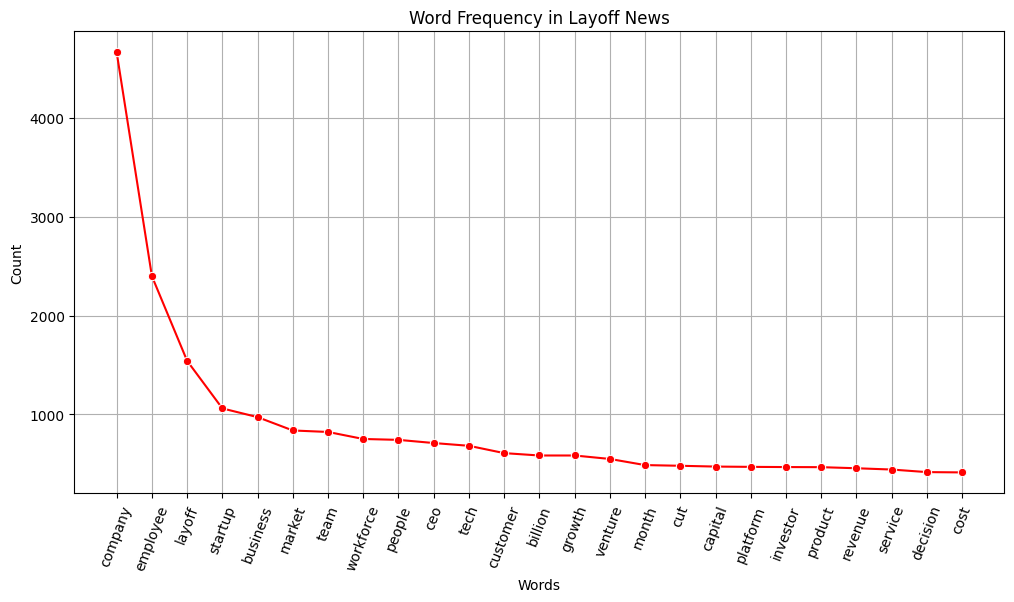

In [ ]:
with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

documents = [entry["Extracted Article"] for entry in data if "Extracted Article" in entry]

with open(stop_word_path, "r", encoding="utf-8") as file:
    stopwords_list = file.read().splitlines()
stopwords = set(stopwords_list)

lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'nbsp|[^\w\s]', ' ', text)
    text = re.sub(r'\b\d+\b', '', text)
    words = text.lower().split()
    words = [word for word in words if word not in stopwords]
    words = [lemmatizer.lemmatize(word) for word in words]
    return words

processed_docs = [preprocess(doc) for doc in documents]
all_words = [word for doc in processed_docs for word in doc]


word_freq = Counter(all_words).most_common(25)
df_words = pd.DataFrame(word_freq, columns=["Word", "Frequency"])

plt.figure(figsize=(12, 6))
sns.lineplot(x=df_words.index, y=df_words["Frequency"], marker="o", color="red", legend=False)
plt.xticks(df_words.index, df_words["Word"], rotation=69)
plt.title("Word Frequency in Layoff News")
plt.xlabel("Words")
plt.ylabel("Count")
plt.grid()
plt.show()